In [2]:
import os
import andes
import numpy as np
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt
import scipy.stats as stat

from andes.interop.pandapower import to_pandapower, runopp_map
from andes.interop.pandapower import add_gencost, build_group_table
andes.config_logger(stream_level=20)
from math import ceil, floor

# virtual inertia scheduling class
from pdpower import make_link_table
from visopf import vis2_tds, loadnn


In [3]:
# adnes, pandapower version
print(andes.__version__)
print(pp.__version__)

1.7.0.post53.dev0+g4b1b34fb
2.8.0


# Import data

## andes attribute

In [4]:
# ss0 is used for PP conversion
dir_path = os.path.abspath('..')
case_path = '/VIS_opf/ieee39_vis_tds.xlsx'
case = dir_path + case_path
ssa = andes.load(case,
                 setup=True,
                 no_output=True,
                 default_config=False)

# Set output mode as 'manual'
ssa.TDS.config.save_mode = 'manual'

# set PQ constant load
ssa.PQ.config.p2p = 1
ssa.PQ.config.q2q = 1
ssa.PQ.config.p2z = 0
ssa.PQ.config.q2z = 0
ssa.PQ.pq2z = 0

# Turn on 'numba' to accelerate TDS.
ssa.config.numba

Working directory: "/Users/buxinshe/Documents/git-repo/andes/bshe/VIS_opf"
> Loaded config from file "/Users/buxinshe/.andes/andes.rc"
> Loaded generated Python code in "/Users/buxinshe/.andes/pycode".
Parsing input file "/Users/buxinshe/Documents/git-repo/andes/bshe/VIS_opf/ieee39_vis_tds.xlsx"...
Input file parsed in 0.0742 seconds.
ACEc <1> added BusFreq <BusFreq_17> linked to bus <1>
System internal structure set up in 0.0235 seconds.


0

## load profile

In [5]:
# --- read load from ssa ---
ptotal = ssa.PQ.as_df()['p0'].sum()
print('ANDES total load is:',ptotal.round(4),'p.u.')

# --- scale load curve ---
ddata_path = '/VIS_opf/dsyn.csv'
ddata = dir_path + ddata_path
d_syn = pd.read_csv(ddata)

caseH = 10
# the coefficient can be adjusted to fit the case
if caseH == 10: # load prfile at 10am
    d_syn['sload'] = 1*(d_syn['ha10'] - d_syn['ha10'].min()) / d_syn['ha10'].min() + 1
if caseH == 18: # load prfile at 6pm
    d_syn['sload'] = 2*(d_syn['ha18'] - d_syn['ha18'].min()) / d_syn['ha18'].min() + 1

# smooth
d_syn['sload'] = d_syn['sload'].rolling(20).mean()
    
# calculate expected load
step = 300
d_exp = d_syn.groupby(d_syn.index // step).mean().copy()
d_exp['time'] = range(0, 3600, 300)

# align starting point of load with starting point of dispatch results
d_syn['sload'][0] = d_exp['sload'].iloc[0]
d_syn['sload'][1:100] = None
d_syn['sload'] = d_syn['sload'].interpolate(method='polynomial', order=3)

ystep = list(d_exp['sload'])
ystep.insert(0, d_exp['sload'].iloc[0])

ANDES total load is: 58.564 p.u.


In [6]:
d_syn # load profile with TDS inverval (1s)

,time,h10,h18,ha10,ha18,sload
0,0,4978.800000,7459.500000,5162.454000,7441.173000,1.055503
1,1,4978.758667,7459.455333,5160.978067,7440.724133,1.055374
2,2,4978.717333,7459.410667,5159.502133,7440.275267,1.055254
3,3,4978.676000,7459.366000,5158.026200,7439.826400,1.055142
4,4,4978.634667,7459.321333,5156.550267,7439.377533,1.055039
...,...,...,...,...,...,...
3595,3595,5236.523333,7745.296667,5197.508333,7671.689667,1.076477
3596,3596,5236.958667,7745.397333,5196.173067,7671.962933,1.076391
3597,3597,5237.394000,7745.498000,5194.837800,7672.236200,1.076284
3598,3598,5237.829333,7745.598667,5193.502533,7672.509467,1.076156


In [7]:
ystep # load profile with dispatch interval (300s, 5mins)

[1.0555031709041927,
 1.0555031709041927,
 1.016876029042204,
 1.039358429662416,
 1.0476457548742757,
 1.0650078929453062,
 1.0679651172652076,
 1.050017343129504,
 1.0400943896685766,
 1.0559333102231305,
 1.07152626044408,
 1.0632047614278262,
 1.0590590776327036]

Text(0.5, 0, 'Time [s]')

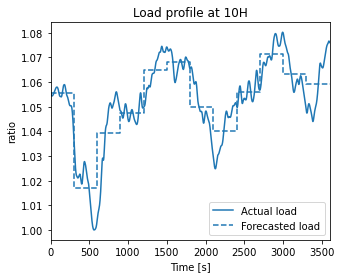

In [8]:
# --- plot load curve ---
fig_load, ax_load = plt.subplots(figsize=(5, 4))

# tds load profile
ax_load.plot(
                d_syn['time'], 
                d_syn['sload'], 
                color='tab:blue', 
                linestyle='-'
            )
# ED load profile
ax_load.step(
                range(0,3900,300), 
                ystep, 
                color='tab:blue', 
                linestyle='--'
            )
            
ax_load.set_xlim([0, 3600])
ax_load.legend(['Actual load', 'Forecasted load'])
ax_load.set_title(f'Load profile at {caseH}H')
ax_load.set_ylabel('ratio')
ax_load.set_xlabel('Time [s]')

## setup pandapower and vis gorubipy instance

### vis gurobipy instance

In [9]:
# get neural network data
nn_path = '/VIS_opf/NN_train'
nn, norm = loadnn(nn_path)

# ini visopf attribute
ssvis = vis2_tds(norm=norm, nn=nn, dpe=0, rocof_lim=0.033, nadir_lim=0.01)

# set vsg gen
vsg_ieee39 = ['PV_1', 'PV_6', 'PV_8', 'PV_9']

# load from andes
ssvis.from_andes(ssa, vsg_ieee39, Sbase=1000)

# add gen cost:
# Note: if two gens have the same cost, optimization results of
#       pandapower and gurobipy may be different.
linearcost = [
                0.5,   # PV_1 vsg
                1, 
                1.5,
                0.8, 
                0.8, 
                1,     # PV_6 vsg
                1, 
                0.6,   # PV_8 vsg
                0.5,   # PV_9 vsg 
                1.5    # slack
            ]

# set up cost
ssvis.cost['c1'] = linearcost
ssvis.update_dict()

ssvis.cost

Restricted license - for non-production use only - expires 2023-10-25


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0042 seconds.
0: |F(x)| = 7.561249598
1: |F(x)| = 2.916162515
2: |F(x)| = 0.1315330771
3: |F(x)| = 0.0003398595952
4: |F(x)| = 4.189813829e-09
Converged in 5 iterations in 0.0056 seconds.
Power flow results are consistent. Conversion is successful.
GSF is consistent.
Note: Control (dynamic) parameters are renormalized based on case Sbase rather then to andes base


,idx,c2,c1,c0,cru,crd
0,PV_1,0,0.5,0,0,0
1,PV_2,0,1.0,0,0,0
2,PV_3,0,1.5,0,0,0
3,PV_4,0,0.8,0,0,0
4,PV_5,0,0.8,0,0,0
5,PV_6,0,1.0,0,0,0
6,PV_7,0,1.0,0,0,0
7,PV_8,0,0.6,0,0,0
8,PV_9,0,0.5,0,0,0
9,Slack_10,0,1.5,0,0,0


### pandapower

In [10]:
# convert andes to a pandapower instance
ssp = to_pandapower(ssa)

# set up pandapower gen cost
gen_cost = np.array([[2., 0., 0., 3., 0., 0., 0.]] * ssp.gen.shape[0])
gen_cost[:, 5] = linearcost  # c1

add_gencost(ssp, gen_cost)

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0034 seconds.
0: |F(x)| = 7.561249598
1: |F(x)| = 2.916162515
2: |F(x)| = 0.1315330771
3: |F(x)| = 0.0003398595952
4: |F(x)| = 4.189813829e-09
Converged in 5 iterations in 0.0055 seconds.
Power flow results are consistent. Conversion is successful.


True

In [11]:
# run pandapower dc opf
pp.rundcopp(ssp)
ppres = ssp.res_gen.copy()

# run gorubi dc opf
ssdc = ssvis.to_dcopf()
gb_res = ssdc.get_res()

ppres['p_mw(gurobi)'] = ssp.sn_mva * gb_res['pg'].values

print(f"pp cost={ssp.res_cost / 100}, gb cost={ssdc.mdl.getObjective().getValue()}")

ppres

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Successfully build DCOPF model.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 69 rows, 10 columns and 546 nonzeros
Model fingerprint: 0x0765a31b
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [5e-01, 2e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [6e+01, 2e+03]
Presolve removed 68 rows and 5 columns
Presolve time: 0.00s
Presolved: 1 rows, 5 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.5132000e+01   1.553200e+01   0.000000e+00      0s
       1    4.5464000e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.546400000e+01


Successfully solve DCOPF.


pp cost=46.250803380564, gb cost=45.464


,p_mw,q_mvar,va_degree,vm_pu,p_mw(gurobi)
0,899.999999,95.188635,20.432913,1.0,900.0
1,153.100870,311.907993,-3.882734,1.0,556.4
2,100.000000,149.807913,-1.887506,1.0,100.0
3,700.000000,131.573046,22.704821,1.0,700.0
4,700.000000,146.758289,24.062823,1.0,700.0
5,799.999988,228.233225,25.444699,1.0,800.0
6,699.999988,63.490085,29.521461,1.0,100.0
7,503.299156,-28.822379,18.969848,1.0,700.0
8,1000.000000,126.624527,30.817756,1.0,1000.0
9,300.000000,-27.788743,0.000000,1.0,300.0


## Link table between pandapower and andes

In [12]:
# --- link pandapower output to andes key ---
ssa_key = make_link_table(ssa)

# make index table to change pandapower and andes setting point
# pandapwoer uses dataframe index, i.g. 0, 1, 2 ....
# andes uses idx to call variable

# --- add controllable in the link table ---
ssa_bus = ssa.Bus.as_df().reset_index().rename(columns={'uid':'bus_pp', 'idx':'bus_idx'})
ssp_gen = ssp.gen.reset_index().rename(columns={'index':'gen_pp', 'name':'stg_idx', 'controllable':'ctrl'})

ssa_key2 = pd.merge(
                        left=ssa_key,
                        right=ssp_gen[['stg_idx', 'gen_pp', 'ctrl']],
                        on='stg_idx', 
                        how='left'
                    )

# --- device idx ---
# use to set andes setting point
ssa_dg_idx = ssa_key2.dg_idx.dropna().tolist()   
ssa_syg_idx = ssa_key2.syg_idx.dropna().tolist()
ssa_gov_idx = ssa_key2.gov_idx.dropna().tolist() 
ssa_stg_idx = ssa_key2.stg_idx.dropna().tolist() # static gen
ssa_rg_idx = ssa_key2.rg_idx.dropna().tolist()   # renewable gen: vsg

# --- online and controllable device idx ---
ctrl_cond = ssa_key2.ctrl & ssa_key2.stg_u.astype(bool)

ssa_dg_idx_ctrl = ssa_key2.dg_idx[ctrl_cond].dropna().tolist()
ssa_syg_idx_ctrl = ssa_key2.syg_idx[ctrl_cond].dropna().tolist()
ssa_gov_idx_ctrl = ssa_key2.gov_idx[ctrl_cond].dropna().tolist()
ssa_stg_idx_ctrl = ssa_key2.stg_idx[ctrl_cond].dropna().tolist()

# fill NaN with False
ssa_key2.fillna(value=False, inplace=True)

ssa_key2

,stg_name,stg_u,stg_idx,bus_idx,dg_idx,rg_idx,syg_idx,exc_idx,gov_idx,bus_name,gammap,gammaq,gen_pp,ctrl
0,PV_2,1.0,PV_2,31,False,False,GENROU_2,IEEEX1_2,TGOV1_2,GEN31,1.0,1.0,1,True
1,PV_3,1.0,PV_3,32,False,False,GENROU_3,IEEEX1_3,TGOV1_3,GEN32,1.0,1.0,2,True
2,PV_4,1.0,PV_4,33,False,False,GENROU_4,IEEEX1_4,TGOV1_4,GEN33,1.0,1.0,3,True
3,PV_5,1.0,PV_5,34,False,False,GENROU_5,IEEEX1_5,TGOV1_5,GEN34,1.0,1.0,4,True
4,PV_7,1.0,PV_7,36,False,False,GENROU_7,IEEEX1_7,TGOV1_7,GEN36,1.0,1.0,6,True
5,Slack_10,1.0,Slack_10,39,False,False,GENROU_10,IEEEX1_10,TGOV1_10,GEN39,1.0,1.0,9,True
6,PV_1,1.0,PV_1,30,False,VSG_1,False,False,False,GEN30,1.0,1.0,0,True
7,PV_6,1.0,PV_6,35,False,VSG_2,False,False,False,GEN35,1.0,1.0,5,True
8,PV_8,1.0,PV_8,37,False,VSG_3,False,False,False,GEN37,1.0,1.0,7,True
9,PV_9,1.0,PV_9,38,False,VSG_4,False,False,False,GEN38,1.0,1.0,8,True


In [13]:
len(ssa_rg_idx)

4

## Auxliary function

In [14]:
def disturbance(d_syn, idx_ed, intv_ed):
    """
        get disturbance
        
        return:
        ----------
        - load_exp: load forecasted value
        - dpe: delta load change
        - dvsg: vsg gen capacity change
    """
    idx0 = idx_ed * intv_ed # start index
    idx1 = idx0 + intv_ed   # end index

    # --- load change ---
    load = d_syn['sload'].iloc[idx0 : idx1] 
    load_exp = load.mean()

    # --- dpe ---
    if idx_ed == 0:
        dpe = 0
    else:
        load_early = d_syn['sload'].iloc[idx0 - intv_ed : idx1 - intv_ed]
        load_exp_early = load_early.mean()
        dpe = load_exp - load_exp_early

    # --- vsg gen capacity change ---
    # TODO: add vsg gen capacity change
    dvsg = [0] * len(ssa_rg_idx)

    return load_exp, dpe, dvsg

# TDS simulation

## TSD sim parameters

In [15]:
# --- TDS Constants ---
t_total = 3600  # total simulation time

# update interval
intv_ed = 300   # RTED
intv_agc = 4    # AGC
intv_pq = 1     # PQ load
intv_step = 100 # step change to smooth the setpoitns

# number of intervals
n_ed = int(t_total/intv_ed)
n_agc = int(intv_ed/intv_agc)
n_pq = int(intv_agc/intv_pq)
n_step = floor(intv_step/intv_agc)

# --- TDS vars ---
# AGC table
agc_table = ssp.gen[['name']].rename(columns={'name':'stg_idx'})
agc_table['paux'] = 0
agc_res = agc_table[['stg_idx']].copy()

# ACE vars for PI controller
ACE_integral = 0
ACE_raw = 0
Kp = 0.2 # 0.05
Ki = 0.1
ace_res = pd.DataFrame()

# initial load value
ssa_p0 = ssa.PQ.p0.v.copy()
ssa_q0 = ssa.PQ.q0.v.copy()
ssa_pq_idx = ssa.PQ.idx.v
ssa_p0_sum = ssa_p0.sum()

In [16]:
agc_table

,stg_idx,paux
0,PV_1,0
1,PV_2,0
2,PV_3,0
3,PV_4,0
4,PV_5,0
5,PV_6,0
6,PV_7,0
7,PV_8,0
8,PV_9,0
9,Slack_10,0


In [17]:
ssp_gen

,gen_pp,stg_idx,bus,p_mw,vm_pu,sn_mva,min_q_mvar,max_q_mvar,scaling,slack,in_service,slack_weight,type,ctrl,min_p_mw,max_p_mw,power_station_trafo
0,0,PV_1,29,436.086385,1.035534,100.0,-58.084,183.8160,1.0,False,True,0.0,None,True,0.0,900.0,NaN
1,1,PV_2,30,645.999998,1.013246,100.0,-122.665,515.7648,1.0,False,True,0.0,None,True,150.0,900.0,NaN
2,2,PV_3,31,724.999998,1.020528,100.0,-180.218,536.0664,1.0,False,True,0.0,None,True,100.0,800.0,NaN
3,3,PV_4,32,651.999998,1.013430,100.0,-213.780,657.8496,1.0,False,True,0.0,None,True,100.0,700.0,NaN
4,4,PV_5,33,520.000000,1.019109,100.0,-188.028,733.7940,1.0,False,True,0.0,None,True,100.0,700.0,NaN
5,5,PV_6,34,690.000000,1.060000,100.0,-234.972,712.5456,1.0,False,True,0.0,None,True,0.0,800.0,NaN
6,6,PV_7,35,590.000000,1.060000,100.0,-249.132,682.0464,1.0,False,True,0.0,None,True,100.0,700.0,NaN
7,7,PV_8,36,330.000000,1.013996,100.0,-216.122,532.1616,1.0,False,True,0.0,None,True,0.0,700.0,NaN
8,8,PV_9,37,780.000000,1.052803,100.0,-356.889,1001.7300,1.0,False,True,0.0,None,True,0.0,1000.0,NaN
9,9,Slack_10,38,574.170000,1.030000,100.0,-173.261,574.8500,1.0,True,True,0.0,None,True,300.0,1500.0,NaN


## TDS loop

In [18]:
# Reserve some capacity to avoid TDS crush
ssp.gen.max_p_mw = 0.8 * ssp.gen.max_p_mw # for AC

# store original generator data
ssp_gen0 = ssp.gen.copy()

t_total = 700

for time in range(t_total):  # t_total

    # ----------------------- RTED (VIS opf) interval -------------------------
    if time % intv_ed == 0:
        """
            RTED update with vis opf

            attributes:
            ----------
            - 01 get disturbance
            - 02 update visopf instance
            - 03 update pandapower instance
            - 04 update andes instance
        """
        # --- 01 get disturbance ---
        idx_ed = time // intv_ed
        load, dpe, dvsg_capacity = disturbance(d_syn, idx_ed, intv_ed)

        # --- 02 update visopf instance ---
        # load
        ssvis.load['p0'] = ssa_p0 * load # visopf load update
        # dpe
        ssvis.dpe = dpe
        # vsg gen capacity
        # TODO ... update vsg gen capacity of visopf

        ssvis.update_dict()

        # solve visopf
        visres, vsg_res, _ = ssvis.get_res() 

        # --- 03 update pandapwoer instance ---
        # load
        ssp.load.scaling = load
        # pandapower gen
        ssp_gen = pd.merge(
                            left=ssp.gen.rename(columns={'name': 'stg_idx'}),
                            right=visres.rename(columns={'gen': 'stg_idx'}),
                            on='stg_idx',
                            how='left'
                        )

        # vsg power reserve limits
        # TODO: integrate delta vsg capacity change here
        ssp_gen['vsg_up'] = ssp_gen.max_p_mw - ssp_gen.pru * ssp.sn_mva
        ssp_gen['vsg_d'] = ssp_gen.min_p_mw + ssp_gen.prd * ssp.sn_mva

        ssp.gen.max_p_mw = ssp_gen['vsg_up']
        ssp.gen.min_p_mw = ssp_gen['vsg_d']

        # run pandapower ACOPF, modify setpoints
        # store setpoints
        if time > 0:
            p0 = ssp_res['p'].values        # store setpoints
        else:
            p0 = [0] * ssa_key2.shape[0]

        # solve ACOPF
        ssp_res = runopp_map(ssp, ssa_key)  # ACOPF resutls
        ssp_res['p0'] = p0                  # last setpoints
        ssp_res.fillna(False, inplace=True) # Fill NA wil False

        # reset Generator limtis to normal limits
        # TODO: integrate delta vsg capacity change here
        ssp.gen.max_p_mw = ssp_gen0.max_p_mw
        ssp.gen.min_p_mw = ssp_gen0.min_p_mw

        # --- 04 update andes instance ---
        ssa.REGCV1.set(
                        src='M', 
                        idx= ssa.REGCV1.idx.v,
                        attr='v',
                        value= vsg_res['Mvsg']
                    )
        ssa.REGCV1.set(
                        src='D', 
                        idx= ssa.REGCV1.idx.v, 
                        attr='v',
                        value= vsg_res['Dvsg']
                    )

    # ---------------------- AGC interval -------------------------
    """
        AGC update

        attributes:
        ----------
        - 01 assign ACE signla to gen 
        - 02 smooth setpoints
    """
    ace_gain = 1

    if time % intv_agc == 0:
        idx_agc = time // intv_agc - idx_ed * n_agc
        # --- 01 allocate AGC ---

        # ACE_raw > 0: assign to expensive gen
        # ACE_raw < 0: assign to cheap gen
        # Note: allocate to synchronous generator governors
        if ACE_raw > 0:
            agc_idx = ['TGOV1_10', 'TGOV1_2'] # TODO: change to expensive gen
        else:
            agc_idx = ['TGOV1_4', 'TGOV1_5'] # TODO: change to cheap gen

        ssa.TurbineGov.set(
                            src='paux0',
                            idx= agc_idx,
                            attr='v',
                            value= ACE_raw/len(agc_idx) # allocate equally to each agc gen
                        )

        # --- smooth setpoints ---
        if idx_ed == 0:
            ssp_res['pref'] = ssp_res['p']
        else:
            idx_step = min((time - idx_ed * intv_ed) // intv_agc + 1, n_step)

            ssp_res['pref_step'] = ssp_res.p - ssp_res.p0
            # smooth change threshold: 0.1
            # check ssp_res format for vsg setpoints
            large_index = ssp_res['pref_step'][abs(ssp_res['pref_step']) > 0.01].index
            ssp_res['pref_delta'] = ssp_res['pref_step']
            ssp_res['pref_delta'].iloc[large_index] = ssp_res['pref_step'].iloc[large_index] / n_step * idx_step
            ssp_res['pref'] = ssp_res.p0 + ssp_res.pref_delta

            # update SynGen setpoints
            cond_gov = ssp_res.controllable & ssp_res.gov_idx.astype(bool)
            ssa.TurbineGov.set(
                                src='pref0', 
                                idx=ssp_res.gov_idx[cond_gov].tolist(),
                                attr='v',
                                value=ssp_res.pref[cond_gov].values
                            )

            # update DG setpoints
            cond_dg = ssp_res.controllable & ssp_res.dg_idx.astype(bool)
            ssa.DG.set(
                        src='pref0', 
                        idx=ssp_res.dg_idx[cond_dg].tolist(),
                        attr='v', 
                        value=ssp_res.pref[cond_dg].values
                    )
                    
            # update vsg setpoints
            cond_rg = ssp_res.controllable & ssp_res.rg_idx.astype(bool)
            ssa.RenGen.set(
                                src='Pref', 
                                idx=ssp_res.rg_idx[cond_rg].tolist(),
                                attr='v',
                                value=ssp_res.pref[cond_rg].values
                            )

    # ----------------------- load change interval ----------------------
    """
        load change 

        attributes:
        ----------
        - 01 update load
        - 02 run TDS
    """
    # Initially, alter StaticGen: p0 and q0, RUN power flow
    # Otherwise, alter Ppf and Qpf
    if time == 0:
        # get idx from pandapower results
        stg_opf_idx = ssp_res.stg_idx[ssp_res.controllable].tolist()
        stg_opf_val = ssp_res.p[ssp_res.controllable].tolist()
        stg_opf_v = ssp_res.vm_pu[ssp_res.controllable].tolist()

        ssa.StaticGen.set(
                            src='p0',
                            idx=stg_opf_idx,
                            attr='v',
                            value=stg_opf_val
                        )
        ssa.StaticGen.set(
                            src='v0', 
                            idx=stg_opf_idx, 
                            attr='v', 
                            value=stg_opf_v
                        )

        # initial load point set as the dispatch point
        ssa.PQ.set(
                    src='p0', 
                    idx=ssa_pq_idx, 
                    attr='v',
                    value=ssa_p0 * load
                )
        ssa.PQ.set(
                    src='q0', 
                    idx=ssa_pq_idx, 
                    attr='v',
                    value=ssa_q0 * load
                )
        ssa.PFlow.run()
    else:
        ssa.PQ.set(
                    src='Ppf', 
                    idx=ssa_pq_idx, 
                    attr='v',
                    value=ssa_p0 * d_syn['sload'].iloc[time]
                )
        ssa.PQ.set(
                    src='Qpf', 
                    idx=ssa_pq_idx, 
                    attr='v',
                    value=ssa_q0 * d_syn['sload'].iloc[time]
                )

    # ----------------------- run TDS, cal ACE ----------------------
    # run TDS
    ssa.TDS.config.tf = time
    if time == 0:
        ssa.TDS.init()
        ACE_raw = 0 # delete when run TDS ???
    ssa.TDS.run()

    # update AGC using PI Controller
    ACE_integral += ssa.ACEc.ace.v.sum()
    ACE_raw = -( Kp * ssa.ACEc.ace.v.sum() + Ki * ACE_integral )

   # ----------------------- TDS error break ----------------------
    if ssa.exit_code != 0:
        raise ValueError(f"TDS error! Exit with {ssa.exit_code}, end at {time} s.")
        

Successfully build var.
Successfully build obj.
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Successfully build cons.
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1040 rows, 678 columns and 11118 nonzeros
Model fingerprint: 0xa9f01cfa
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [4e-06, 1e+02]
  Objective range  [5e-01, 2e+00]
  Bounds range     [5e-01, 2e+01]
  RHS range        [5e-03, 2e+03]
Found heuristic solution: objective 52.7105802
Presolve removed 667 rows and 425 columns
Presolve time: 0.01s
Presolved: 373 rows, 253 columns, 4226 nonzeros
Variable types: 135 continuous, 118 integer (118 binary)

Root relaxation: objective 4.864039e+01, 216 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Dep

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 48.6404
RoCof prediction: 0 ; RoCof limit: 0.033
Nadir prediction: -0 ; Nadir limit 0.01


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0037 seconds.
0: |F(x)| = 7.814405505
1: |F(x)| = 3.571749389
2: |F(x)| = 0.1960232515
3: |F(x)| = 0.0009244640626
4: |F(x)| = 2.69517626e-08
Converged in 5 iterations in 0.0052 seconds.
GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_2  | 0.042  | 0.036
 GENROU_3  | 0.036  | 0.003
 GENROU_4  | 0.025  | 0.001
 GENROU_5  | 0.050  | 0.001
 GENROU_7  | 0.031  | 0.002
 GENROU_10 | 0.003  | 0.000


Initialization for dynamics completed in 0.0326 seconds.
Initialization was successful.

-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-0 s.
Fixed step size: h=33.33 ms. Shrink if not converged.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=0.00 sec completed in 0.0015 seconds.

-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-1 s.
Fixed step size: h=33.33 ms. Shrink if not converged.


  0%|          | 0/100 [00:00<?, ?%/s]

Current step size is zero. Integration is not permitted.
Simulation to t=1.00 sec completed in 0.0519 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2.00 sec completed in 0.0371 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3.00 sec completed in 0.0411 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=4.00 sec completed in 0.0403 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=5.00 sec completed in 0.0400 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=6.00 sec completed in 0.0534 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=7.00 sec completed in 0.0400 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=8.00 sec completed in 0.0423 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=9.00 sec completed in 0.0478 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=10.00 sec completed in 0.0484 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=11.00 sec completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=12.00 sec completed in 0.0458 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=13.00 sec completed in 0.0422 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=14.00 sec completed in 0.0416 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=15.00 sec completed in 0.0380 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=16.00 sec completed in 0.0377 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=17.00 sec completed in 0.0404 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=18.00 sec completed in 0.0385 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=19.00 sec completed in 0.0466 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=20.00 sec completed in 0.0527 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=21.00 sec completed in 0.0465 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=22.00 sec completed in 0.0362 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=23.00 sec completed in 0.0419 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=24.00 sec completed in 0.0352 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=25.00 sec completed in 0.0392 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=26.00 sec completed in 0.0405 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=27.00 sec completed in 0.0429 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=28.00 sec completed in 0.0427 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=29.00 sec completed in 0.0396 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=30.00 sec completed in 0.0404 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=31.00 sec completed in 0.0408 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=32.00 sec completed in 0.0432 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=33.00 sec completed in 0.0465 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=34.00 sec completed in 0.0421 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=35.00 sec completed in 0.0393 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=36.00 sec completed in 0.0391 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=37.00 sec completed in 0.0436 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=38.00 sec completed in 0.0376 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=39.00 sec completed in 0.0625 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=40.00 sec completed in 0.0482 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=41.00 sec completed in 0.0429 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=42.00 sec completed in 0.0400 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=43.00 sec completed in 0.0410 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=44.00 sec completed in 0.0395 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=45.00 sec completed in 0.0444 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=46.00 sec completed in 0.0407 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=47.00 sec completed in 0.0419 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=48.00 sec completed in 0.0375 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=49.00 sec completed in 0.0519 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=50.00 sec completed in 0.0404 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=51.00 sec completed in 0.0418 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=52.00 sec completed in 0.0411 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=53.00 sec completed in 0.0451 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=54.00 sec completed in 0.0463 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=55.00 sec completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=56.00 sec completed in 0.0481 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=57.00 sec completed in 0.0422 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=58.00 sec completed in 0.0394 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=59.00 sec completed in 0.0386 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=60.00 sec completed in 0.0429 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=61.00 sec completed in 0.0418 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=62.00 sec completed in 0.0447 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=63.00 sec completed in 0.0392 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=64.00 sec completed in 0.0438 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=65.00 sec completed in 0.0415 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=66.00 sec completed in 0.0406 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=67.00 sec completed in 0.0397 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=68.00 sec completed in 0.0420 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=69.00 sec completed in 0.0374 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=70.00 sec completed in 0.0398 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=71.00 sec completed in 0.0385 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=72.00 sec completed in 0.0434 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=73.00 sec completed in 0.0380 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=74.00 sec completed in 0.0406 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=75.00 sec completed in 0.0413 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=76.00 sec completed in 0.0421 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=77.00 sec completed in 0.0398 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=78.00 sec completed in 0.0434 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=79.00 sec completed in 0.0402 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=80.00 sec completed in 0.0379 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=81.00 sec completed in 0.0404 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=82.00 sec completed in 0.0414 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=83.00 sec completed in 0.0388 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=84.00 sec completed in 0.0400 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=85.00 sec completed in 0.0440 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=86.00 sec completed in 0.0446 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=87.00 sec completed in 0.0415 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=88.00 sec completed in 0.0424 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=89.00 sec completed in 0.0443 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=90.00 sec completed in 0.0456 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=91.00 sec completed in 0.0379 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=92.00 sec completed in 0.0374 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=93.00 sec completed in 0.0410 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=94.00 sec completed in 0.0425 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=95.00 sec completed in 0.0424 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=96.00 sec completed in 0.0375 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=97.00 sec completed in 0.0397 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=98.00 sec completed in 0.0426 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=99.00 sec completed in 0.0398 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=100.00 sec completed in 0.0397 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=101.00 sec completed in 0.0409 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=102.00 sec completed in 0.0453 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=103.00 sec completed in 0.0425 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=104.00 sec completed in 0.0387 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=105.00 sec completed in 0.0383 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=106.00 sec completed in 0.0480 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=107.00 sec completed in 0.0445 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=108.00 sec completed in 0.0492 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=109.00 sec completed in 0.0733 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=110.00 sec completed in 0.0470 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=111.00 sec completed in 0.0440 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=112.00 sec completed in 0.0389 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=113.00 sec completed in 0.0406 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=114.00 sec completed in 0.0524 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=115.00 sec completed in 0.0556 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=116.00 sec completed in 0.0533 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=117.00 sec completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=118.00 sec completed in 0.0568 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=119.00 sec completed in 0.0513 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=120.00 sec completed in 0.0548 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=121.00 sec completed in 0.0517 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=122.00 sec completed in 0.0504 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=123.00 sec completed in 0.0467 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=124.00 sec completed in 0.0542 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=125.00 sec completed in 0.0483 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=126.00 sec completed in 0.0529 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=127.00 sec completed in 0.0462 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=128.00 sec completed in 0.0491 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=129.00 sec completed in 0.0483 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=130.00 sec completed in 0.0529 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=131.00 sec completed in 0.0530 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=132.00 sec completed in 0.0471 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=133.00 sec completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=134.00 sec completed in 0.0728 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=135.00 sec completed in 0.0574 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=136.00 sec completed in 0.0641 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=137.00 sec completed in 0.0576 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=138.00 sec completed in 0.0632 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=139.00 sec completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=140.00 sec completed in 0.0508 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=141.00 sec completed in 0.0559 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=142.00 sec completed in 0.0613 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=143.00 sec completed in 0.0591 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=144.00 sec completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=145.00 sec completed in 0.0599 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=146.00 sec completed in 0.0539 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=147.00 sec completed in 0.0537 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=148.00 sec completed in 0.0492 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=149.00 sec completed in 0.0543 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=150.00 sec completed in 0.0556 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=151.00 sec completed in 0.0538 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=152.00 sec completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=153.00 sec completed in 0.0485 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=154.00 sec completed in 0.0484 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=155.00 sec completed in 0.0447 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=156.00 sec completed in 0.0498 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=157.00 sec completed in 0.0461 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=158.00 sec completed in 0.0464 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=159.00 sec completed in 0.0494 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=160.00 sec completed in 0.0491 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=161.00 sec completed in 0.0454 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=162.00 sec completed in 0.0432 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=163.00 sec completed in 0.0534 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=164.00 sec completed in 0.0458 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=165.00 sec completed in 0.0539 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=166.00 sec completed in 0.0470 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=167.00 sec completed in 0.0461 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=168.00 sec completed in 0.0451 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=169.00 sec completed in 0.0471 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=170.00 sec completed in 0.0461 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=171.00 sec completed in 0.0580 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=172.00 sec completed in 0.0522 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=173.00 sec completed in 0.0608 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=174.00 sec completed in 0.0484 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=175.00 sec completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=176.00 sec completed in 0.0478 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=177.00 sec completed in 0.0499 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=178.00 sec completed in 0.0529 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=179.00 sec completed in 0.0631 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=180.00 sec completed in 0.0556 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=181.00 sec completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=182.00 sec completed in 0.0741 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=183.00 sec completed in 0.0832 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=184.00 sec completed in 0.0506 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=185.00 sec completed in 0.0461 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=186.00 sec completed in 0.0637 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=187.00 sec completed in 0.0397 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=188.00 sec completed in 0.0388 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=189.00 sec completed in 0.0381 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=190.00 sec completed in 0.0383 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=191.00 sec completed in 0.0394 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=192.00 sec completed in 0.0408 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=193.00 sec completed in 0.0386 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=194.00 sec completed in 0.0415 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=195.00 sec completed in 0.0468 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=196.00 sec completed in 0.0559 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=197.00 sec completed in 0.0486 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=198.00 sec completed in 0.0473 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=199.00 sec completed in 0.0486 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=200.00 sec completed in 0.0500 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=201.00 sec completed in 0.0407 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=202.00 sec completed in 0.0393 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=203.00 sec completed in 0.0405 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=204.00 sec completed in 0.0370 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=205.00 sec completed in 0.0458 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=206.00 sec completed in 0.0479 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=207.00 sec completed in 0.0543 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=208.00 sec completed in 0.0479 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=209.00 sec completed in 0.0432 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=210.00 sec completed in 0.0382 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=211.00 sec completed in 0.0380 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=212.00 sec completed in 0.0432 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=213.00 sec completed in 0.0449 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=214.00 sec completed in 0.0458 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=215.00 sec completed in 0.0443 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=216.00 sec completed in 0.0381 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=217.00 sec completed in 0.0475 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=218.00 sec completed in 0.0381 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=219.00 sec completed in 0.0373 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=220.00 sec completed in 0.0376 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=221.00 sec completed in 0.0367 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=222.00 sec completed in 0.0373 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=223.00 sec completed in 0.0356 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=224.00 sec completed in 0.0372 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=225.00 sec completed in 0.0372 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=226.00 sec completed in 0.0365 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=227.00 sec completed in 0.0363 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=228.00 sec completed in 0.0395 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=229.00 sec completed in 0.0414 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=230.00 sec completed in 0.0444 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=231.00 sec completed in 0.0458 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=232.00 sec completed in 0.0419 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=233.00 sec completed in 0.0386 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=234.00 sec completed in 0.0388 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=235.00 sec completed in 0.0375 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=236.00 sec completed in 0.0372 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=237.00 sec completed in 0.0412 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=238.00 sec completed in 0.0399 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=239.00 sec completed in 0.0375 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=240.00 sec completed in 0.0389 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=241.00 sec completed in 0.0380 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=242.00 sec completed in 0.0379 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=243.00 sec completed in 0.0376 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=244.00 sec completed in 0.0378 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=245.00 sec completed in 0.0373 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=246.00 sec completed in 0.0376 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=247.00 sec completed in 0.0362 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=248.00 sec completed in 0.0373 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=249.00 sec completed in 0.0367 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=250.00 sec completed in 0.0371 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=251.00 sec completed in 0.0366 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=252.00 sec completed in 0.0389 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=253.00 sec completed in 0.0393 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=254.00 sec completed in 0.0488 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=255.00 sec completed in 0.0430 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=256.00 sec completed in 0.0375 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=257.00 sec completed in 0.0428 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=258.00 sec completed in 0.0417 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=259.00 sec completed in 0.0402 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=260.00 sec completed in 0.0487 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=261.00 sec completed in 0.0363 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=262.00 sec completed in 0.0348 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=263.00 sec completed in 0.0367 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=264.00 sec completed in 0.0410 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=265.00 sec completed in 0.0388 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=266.00 sec completed in 0.0395 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=267.00 sec completed in 0.0358 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=268.00 sec completed in 0.0359 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=269.00 sec completed in 0.0413 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=270.00 sec completed in 0.0463 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=271.00 sec completed in 0.0456 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=272.00 sec completed in 0.0385 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=273.00 sec completed in 0.0380 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=274.00 sec completed in 0.0359 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=275.00 sec completed in 0.0364 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=276.00 sec completed in 0.0417 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=277.00 sec completed in 0.0391 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=278.00 sec completed in 0.0443 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=279.00 sec completed in 0.0378 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=280.00 sec completed in 0.0512 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=281.00 sec completed in 0.0537 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=282.00 sec completed in 0.0483 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=283.00 sec completed in 0.0456 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=284.00 sec completed in 0.0445 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=285.00 sec completed in 0.0435 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=286.00 sec completed in 0.0439 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=287.00 sec completed in 0.0832 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=288.00 sec completed in 0.0565 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=289.00 sec completed in 0.0541 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=290.00 sec completed in 0.0495 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=291.00 sec completed in 0.0398 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=292.00 sec completed in 0.0523 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=293.00 sec completed in 0.0460 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=294.00 sec completed in 0.0600 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=295.00 sec completed in 0.0514 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=296.00 sec completed in 0.0595 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=297.00 sec completed in 0.0474 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=298.00 sec completed in 0.0533 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=299.00 sec completed in 0.0478 seconds.


Successfully build var.
Successfully build obj.
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Successfully build cons.
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0xfc36eca5
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [8e-08, 1e+02]
  Objective range  [5e-01, 2e+00]
  Bounds range     [5e-01, 2e+01]
  RHS range        [5e-03, 2e+03]
Found heuristic solution: objective 53.1784916
Presolve removed 634 rows and 384 columns
Presolve time: 0.02s
Presolved: 406 rows, 294 columns, 4879 nonzeros
Variable types: 176 continuous, 118 integer (118 binary)

Root relaxation: objective 4.645233e+01, 203 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Dep

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 46.4523
RoCof prediction: -0.00642729 ; RoCof limit: 0.033
Nadir prediction: 0.00123191 ; Nadir limit 0.01
    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   Fals

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=300.00 sec completed in 0.0616 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=301.00 sec completed in 0.0576 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=302.00 sec completed in 0.0478 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=303.00 sec completed in 0.0496 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=304.00 sec completed in 0.0569 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=305.00 sec completed in 0.0521 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=306.00 sec completed in 0.0502 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=307.00 sec completed in 0.0476 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=308.00 sec completed in 0.0549 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=309.00 sec completed in 0.0563 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=310.00 sec completed in 0.0611 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=311.00 sec completed in 0.0601 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=312.00 sec completed in 0.0529 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=313.00 sec completed in 0.0469 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=314.00 sec completed in 0.0478 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=315.00 sec completed in 0.0512 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=316.00 sec completed in 0.0566 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=317.00 sec completed in 0.0454 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=318.00 sec completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=319.00 sec completed in 0.0440 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=320.00 sec completed in 0.0493 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=321.00 sec completed in 0.0445 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=322.00 sec completed in 0.0475 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=323.00 sec completed in 0.0485 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=324.00 sec completed in 0.0568 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=325.00 sec completed in 0.0468 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=326.00 sec completed in 0.0448 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=327.00 sec completed in 0.0471 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=328.00 sec completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=329.00 sec completed in 0.0620 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=330.00 sec completed in 0.0523 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=331.00 sec completed in 0.0520 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=332.00 sec completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=333.00 sec completed in 0.0756 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=334.00 sec completed in 0.0485 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=335.00 sec completed in 0.0370 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=336.00 sec completed in 0.0571 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=337.00 sec completed in 0.0509 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=338.00 sec completed in 0.0438 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=339.00 sec completed in 0.0508 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=340.00 sec completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=341.00 sec completed in 0.0524 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=342.00 sec completed in 0.0572 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=343.00 sec completed in 0.0364 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=344.00 sec completed in 0.0643 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=345.00 sec completed in 0.0575 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=346.00 sec completed in 0.0409 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=347.00 sec completed in 0.0418 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=348.00 sec completed in 0.0612 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=349.00 sec completed in 0.0479 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=350.00 sec completed in 0.0405 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=351.00 sec completed in 0.0361 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=352.00 sec completed in 0.0534 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=353.00 sec completed in 0.0537 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=354.00 sec completed in 0.0467 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=355.00 sec completed in 0.0383 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=356.00 sec completed in 0.0609 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=357.00 sec completed in 0.0621 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=358.00 sec completed in 0.0424 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=359.00 sec completed in 0.0436 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=360.00 sec completed in 0.0587 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=361.00 sec completed in 0.0584 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=362.00 sec completed in 0.0482 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=363.00 sec completed in 0.0566 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=364.00 sec completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=365.00 sec completed in 0.0698 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=366.00 sec completed in 0.0582 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=367.00 sec completed in 0.0712 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=368.00 sec completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=369.00 sec completed in 0.0600 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=370.00 sec completed in 0.0515 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=371.00 sec completed in 0.0518 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=372.00 sec completed in 0.0614 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=373.00 sec completed in 0.0543 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=374.00 sec completed in 0.0512 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=375.00 sec completed in 0.0572 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=376.00 sec completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=377.00 sec completed in 0.0641 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=378.00 sec completed in 0.0512 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=379.00 sec completed in 0.0540 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=380.00 sec completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=381.00 sec completed in 0.0615 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=382.00 sec completed in 0.0545 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=383.00 sec completed in 0.0563 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=384.00 sec completed in 0.0876 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=385.00 sec completed in 0.0606 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=386.00 sec completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=387.00 sec completed in 0.0696 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=388.00 sec completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=389.00 sec completed in 0.0810 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=390.00 sec completed in 0.0645 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=391.00 sec completed in 0.0658 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=392.00 sec completed in 0.0728 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=393.00 sec completed in 0.0642 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=394.00 sec completed in 0.0613 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=395.00 sec completed in 0.0581 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=396.00 sec completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=397.00 sec completed in 0.0624 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=398.00 sec completed in 0.0573 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=399.00 sec completed in 0.0661 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=400.00 sec completed in 0.0623 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=401.00 sec completed in 0.0587 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=402.00 sec completed in 0.0586 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=403.00 sec completed in 0.0726 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=404.00 sec completed in 0.1170 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=405.00 sec completed in 0.0834 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=406.00 sec completed in 0.0840 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=407.00 sec completed in 0.0713 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=408.00 sec completed in 0.0572 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=409.00 sec completed in 0.0624 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=410.00 sec completed in 0.0543 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=411.00 sec completed in 0.0651 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=412.00 sec completed in 0.0537 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=413.00 sec completed in 0.0463 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=414.00 sec completed in 0.0558 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=415.00 sec completed in 0.0496 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=416.00 sec completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=417.00 sec completed in 0.0531 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=418.00 sec completed in 0.0476 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=419.00 sec completed in 0.0485 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=420.00 sec completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=421.00 sec completed in 0.0739 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=422.00 sec completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=423.00 sec completed in 0.0643 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=424.00 sec completed in 0.0749 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=425.00 sec completed in 0.0609 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=426.00 sec completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=427.00 sec completed in 0.0542 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=428.00 sec completed in 0.0840 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=429.00 sec completed in 0.0584 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=430.00 sec completed in 0.0663 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=431.00 sec completed in 0.0575 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=432.00 sec completed in 0.1036 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=433.00 sec completed in 0.0633 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=434.00 sec completed in 0.0565 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=435.00 sec completed in 0.0843 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=436.00 sec completed in 0.1100 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=437.00 sec completed in 0.0486 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=438.00 sec completed in 0.0602 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=439.00 sec completed in 0.0582 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=440.00 sec completed in 0.0759 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=441.00 sec completed in 0.0499 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=442.00 sec completed in 0.0603 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=443.00 sec completed in 0.0534 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=444.00 sec completed in 0.0561 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=445.00 sec completed in 0.0833 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=446.00 sec completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=447.00 sec completed in 0.0499 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=448.00 sec completed in 0.0613 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=449.00 sec completed in 0.0833 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=450.00 sec completed in 0.0678 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=451.00 sec completed in 0.0689 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=452.00 sec completed in 0.0850 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=453.00 sec completed in 0.0512 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=454.00 sec completed in 0.0644 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=455.00 sec completed in 0.0595 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=456.00 sec completed in 0.0773 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=457.00 sec completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=458.00 sec completed in 0.0590 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=459.00 sec completed in 0.0487 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=460.00 sec completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=461.00 sec completed in 0.0652 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=462.00 sec completed in 0.0518 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=463.00 sec completed in 0.0528 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=464.00 sec completed in 0.0972 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=465.00 sec completed in 0.0898 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=466.00 sec completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=467.00 sec completed in 0.0657 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=468.00 sec completed in 0.0770 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=469.00 sec completed in 0.0577 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=470.00 sec completed in 0.0472 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=471.00 sec completed in 0.0612 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=472.00 sec completed in 0.0891 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=473.00 sec completed in 0.0572 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=474.00 sec completed in 0.0880 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=475.00 sec completed in 0.0483 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=476.00 sec completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=477.00 sec completed in 0.0529 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=478.00 sec completed in 0.0506 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=479.00 sec completed in 0.0542 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=480.00 sec completed in 0.0872 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=481.00 sec completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=482.00 sec completed in 0.0638 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=483.00 sec completed in 0.0737 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=484.00 sec completed in 0.0974 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=485.00 sec completed in 0.0544 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=486.00 sec completed in 0.0531 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=487.00 sec completed in 0.0444 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=488.00 sec completed in 0.0658 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=489.00 sec completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=490.00 sec completed in 0.0573 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=491.00 sec completed in 0.0773 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=492.00 sec completed in 0.0743 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=493.00 sec completed in 0.1036 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=494.00 sec completed in 0.0643 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=495.00 sec completed in 0.0574 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=496.00 sec completed in 0.0815 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=497.00 sec completed in 0.0600 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=498.00 sec completed in 0.0538 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=499.00 sec completed in 0.0666 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=500.00 sec completed in 0.0630 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=501.00 sec completed in 0.0622 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=502.00 sec completed in 0.0608 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=503.00 sec completed in 0.0652 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=504.00 sec completed in 0.0562 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=505.00 sec completed in 0.0535 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=506.00 sec completed in 0.0514 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=507.00 sec completed in 0.0499 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=508.00 sec completed in 0.0598 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=509.00 sec completed in 0.0476 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=510.00 sec completed in 0.0432 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=511.00 sec completed in 0.0418 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=512.00 sec completed in 0.0468 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=513.00 sec completed in 0.0486 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=514.00 sec completed in 0.0374 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=515.00 sec completed in 0.0409 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=516.00 sec completed in 0.0463 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=517.00 sec completed in 0.0427 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=518.00 sec completed in 0.0473 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=519.00 sec completed in 0.0443 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=520.00 sec completed in 0.0628 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=521.00 sec completed in 0.0414 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=522.00 sec completed in 0.0403 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=523.00 sec completed in 0.0429 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=524.00 sec completed in 0.0504 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=525.00 sec completed in 0.0539 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=526.00 sec completed in 0.0424 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=527.00 sec completed in 0.0391 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=528.00 sec completed in 0.0387 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=529.00 sec completed in 0.0422 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=530.00 sec completed in 0.0405 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=531.00 sec completed in 0.0691 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=532.00 sec completed in 0.0444 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=533.00 sec completed in 0.0415 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=534.00 sec completed in 0.0380 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=535.00 sec completed in 0.0414 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=536.00 sec completed in 0.0472 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=537.00 sec completed in 0.0407 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=538.00 sec completed in 0.0455 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=539.00 sec completed in 0.0426 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=540.00 sec completed in 0.0452 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=541.00 sec completed in 0.0453 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=542.00 sec completed in 0.0480 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=543.00 sec completed in 0.0393 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=544.00 sec completed in 0.0445 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=545.00 sec completed in 0.0485 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=546.00 sec completed in 0.0416 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=547.00 sec completed in 0.0422 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=548.00 sec completed in 0.0519 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=549.00 sec completed in 0.0381 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=550.00 sec completed in 0.0389 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=551.00 sec completed in 0.0378 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=552.00 sec completed in 0.0507 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=553.00 sec completed in 0.0390 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=554.00 sec completed in 0.0528 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=555.00 sec completed in 0.0794 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=556.00 sec completed in 0.0520 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=557.00 sec completed in 0.0759 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=558.00 sec completed in 0.0489 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=559.00 sec completed in 0.0453 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=560.00 sec completed in 0.0858 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=561.00 sec completed in 0.0392 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=562.00 sec completed in 0.0430 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=563.00 sec completed in 0.0439 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=564.00 sec completed in 0.0482 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=565.00 sec completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=566.00 sec completed in 0.0446 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=567.00 sec completed in 0.0398 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=568.00 sec completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=569.00 sec completed in 0.0462 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=570.00 sec completed in 0.0516 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=571.00 sec completed in 0.0556 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=572.00 sec completed in 0.0394 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=573.00 sec completed in 0.0479 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=574.00 sec completed in 0.0399 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=575.00 sec completed in 0.0465 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=576.00 sec completed in 0.0510 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=577.00 sec completed in 0.0408 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=578.00 sec completed in 0.0477 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=579.00 sec completed in 0.0709 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=580.00 sec completed in 0.0421 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=581.00 sec completed in 0.0498 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=582.00 sec completed in 0.0897 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=583.00 sec completed in 0.0476 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=584.00 sec completed in 0.0441 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=585.00 sec completed in 0.0536 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=586.00 sec completed in 0.0394 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=587.00 sec completed in 0.0473 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=588.00 sec completed in 0.0436 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=589.00 sec completed in 0.0418 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=590.00 sec completed in 0.0383 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=591.00 sec completed in 0.0461 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=592.00 sec completed in 0.0559 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=593.00 sec completed in 0.0400 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=594.00 sec completed in 0.0463 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=595.00 sec completed in 0.0584 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.200000  1.389594  1.081553       30          True   False   
1      PV_2  7.200000  1.853496  1.010064       31          True   False   
2      PV_3  4.597452  0.854133  1.040648       32          True   False   
3      PV_4  5.600000  0.942356  1.041853       33          True   False   
4      PV_5  5.600000  1.473036  1.051478       34          True   False   
5      PV_6  6.400000  2.066995  1.096870       35          True   False   
6      PV_7  5.600000  0.525128  1.100000       36          True   False   
7      PV_8  5.600000  0.432583  1.078837       37          True   False   
8      PV_9  8.000000  0.983734  1.085895       38          True   False   
9  Slack_10  4.142564  0.304492  1.087196       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000  6.037784e-09   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=596.00 sec completed in 0.0388 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=597.00 sec completed in 0.0394 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=598.00 sec completed in 0.0486 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=599.00 sec completed in 0.0388 seconds.


Successfully build var.
Successfully build obj.
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Successfully build cons.
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0x0de4f444
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [5e-08, 1e+02]
  Objective range  [5e-01, 2e+00]
  Bounds range     [5e-01, 2e+01]
  RHS range        [5e-03, 2e+03]
Found heuristic solution: objective 63.2538504
Presolve removed 634 rows and 384 columns
Presolve time: 0.02s
Presolved: 406 rows, 294 columns, 4878 nonzeros
Variable types: 176 continuous, 118 integer (118 binary)

Root relaxation: objective 4.777405e+01, 291 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Dep

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 47.7765
RoCof prediction: 0.0037368 ; RoCof limit: 0.033
Nadir prediction: -0.000695096 ; Nadir limit 0.01
    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.194614  1.495886  1.084399       30          True   False   
1      PV_2  7.200000  2.083885  1.014936       31          True   False   
2      PV_3  5.527706  0.956448  1.040914       32          True   False   
3      PV_4  5.600000  0.962383  1.042124       33          True   False   
4      PV_5  5.600000  1.495374  1.051695       34          True   False   
5      PV_6  6.383854  2.096519  1.097264       35          True   False   
6      PV_7  5.600000  0.529790  1.100000       36          True   False   
7      PV_8  5.594614  0.445771  1.079131       37          True   False   
8      PV_9  7.994614  1.039289  1.087383       38          True   False   
9  Slack_10  4.558161  0.279206  1.085972       39          True   Fals

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=600.00 sec completed in 0.0545 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=601.00 sec completed in 0.0376 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=602.00 sec completed in 0.0440 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=603.00 sec completed in 0.0610 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.194614  1.495886  1.084399       30          True   False   
1      PV_2  7.200000  2.083885  1.014936       31          True   False   
2      PV_3  5.527706  0.956448  1.040914       32          True   False   
3      PV_4  5.600000  0.962383  1.042124       33          True   False   
4      PV_5  5.600000  1.495374  1.051695       34          True   False   
5      PV_6  6.383854  2.096519  1.097264       35          True   False   
6      PV_7  5.600000  0.529790  1.100000       36          True   False   
7      PV_8  5.594614  0.445771  1.079131       37          True   False   
8      PV_9  7.994614  1.039289  1.087383       38          True   False   
9  Slack_10  4.558161  0.279206  1.085972       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000 -5.386048e-03   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=604.00 sec completed in 0.0498 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=605.00 sec completed in 0.0794 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=606.00 sec completed in 0.1205 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=607.00 sec completed in 0.1133 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.194614  1.495886  1.084399       30          True   False   
1      PV_2  7.200000  2.083885  1.014936       31          True   False   
2      PV_3  5.527706  0.956448  1.040914       32          True   False   
3      PV_4  5.600000  0.962383  1.042124       33          True   False   
4      PV_5  5.600000  1.495374  1.051695       34          True   False   
5      PV_6  6.383854  2.096519  1.097264       35          True   False   
6      PV_7  5.600000  0.529790  1.100000       36          True   False   
7      PV_8  5.594614  0.445771  1.079131       37          True   False   
8      PV_9  7.994614  1.039289  1.087383       38          True   False   
9  Slack_10  4.558161  0.279206  1.085972       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000 -5.386048e-03   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=608.00 sec completed in 0.2125 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=609.00 sec completed in 0.1144 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=610.00 sec completed in 0.0794 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=611.00 sec completed in 0.0828 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.194614  1.495886  1.084399       30          True   False   
1      PV_2  7.200000  2.083885  1.014936       31          True   False   
2      PV_3  5.527706  0.956448  1.040914       32          True   False   
3      PV_4  5.600000  0.962383  1.042124       33          True   False   
4      PV_5  5.600000  1.495374  1.051695       34          True   False   
5      PV_6  6.383854  2.096519  1.097264       35          True   False   
6      PV_7  5.600000  0.529790  1.100000       36          True   False   
7      PV_8  5.594614  0.445771  1.079131       37          True   False   
8      PV_9  7.994614  1.039289  1.087383       38          True   False   
9  Slack_10  4.558161  0.279206  1.085972       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000 -5.386048e-03   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=612.00 sec completed in 0.0863 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=613.00 sec completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=614.00 sec completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=615.00 sec completed in 0.0815 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.194614  1.495886  1.084399       30          True   False   
1      PV_2  7.200000  2.083885  1.014936       31          True   False   
2      PV_3  5.527706  0.956448  1.040914       32          True   False   
3      PV_4  5.600000  0.962383  1.042124       33          True   False   
4      PV_5  5.600000  1.495374  1.051695       34          True   False   
5      PV_6  6.383854  2.096519  1.097264       35          True   False   
6      PV_7  5.600000  0.529790  1.100000       36          True   False   
7      PV_8  5.594614  0.445771  1.079131       37          True   False   
8      PV_9  7.994614  1.039289  1.087383       38          True   False   
9  Slack_10  4.558161  0.279206  1.085972       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000 -5.386048e-03   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=616.00 sec completed in 0.0765 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=617.00 sec completed in 0.0475 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=618.00 sec completed in 0.0557 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=619.00 sec completed in 0.0463 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.194614  1.495886  1.084399       30          True   False   
1      PV_2  7.200000  2.083885  1.014936       31          True   False   
2      PV_3  5.527706  0.956448  1.040914       32          True   False   
3      PV_4  5.600000  0.962383  1.042124       33          True   False   
4      PV_5  5.600000  1.495374  1.051695       34          True   False   
5      PV_6  6.383854  2.096519  1.097264       35          True   False   
6      PV_7  5.600000  0.529790  1.100000       36          True   False   
7      PV_8  5.594614  0.445771  1.079131       37          True   False   
8      PV_9  7.994614  1.039289  1.087383       38          True   False   
9  Slack_10  4.558161  0.279206  1.085972       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000 -5.386048e-03   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=620.00 sec completed in 0.0527 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=621.00 sec completed in 0.0397 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=622.00 sec completed in 0.0468 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=623.00 sec completed in 0.0411 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.194614  1.495886  1.084399       30          True   False   
1      PV_2  7.200000  2.083885  1.014936       31          True   False   
2      PV_3  5.527706  0.956448  1.040914       32          True   False   
3      PV_4  5.600000  0.962383  1.042124       33          True   False   
4      PV_5  5.600000  1.495374  1.051695       34          True   False   
5      PV_6  6.383854  2.096519  1.097264       35          True   False   
6      PV_7  5.600000  0.529790  1.100000       36          True   False   
7      PV_8  5.594614  0.445771  1.079131       37          True   False   
8      PV_9  7.994614  1.039289  1.087383       38          True   False   
9  Slack_10  4.558161  0.279206  1.085972       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000 -5.386048e-03   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=624.00 sec completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=625.00 sec completed in 0.0817 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=626.00 sec completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=627.00 sec completed in 0.0559 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.194614  1.495886  1.084399       30          True   False   
1      PV_2  7.200000  2.083885  1.014936       31          True   False   
2      PV_3  5.527706  0.956448  1.040914       32          True   False   
3      PV_4  5.600000  0.962383  1.042124       33          True   False   
4      PV_5  5.600000  1.495374  1.051695       34          True   False   
5      PV_6  6.383854  2.096519  1.097264       35          True   False   
6      PV_7  5.600000  0.529790  1.100000       36          True   False   
7      PV_8  5.594614  0.445771  1.079131       37          True   False   
8      PV_9  7.994614  1.039289  1.087383       38          True   False   
9  Slack_10  4.558161  0.279206  1.085972       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000 -5.386048e-03   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=628.00 sec completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=629.00 sec completed in 0.0626 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=630.00 sec completed in 0.0473 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=631.00 sec completed in 0.1607 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.194614  1.495886  1.084399       30          True   False   
1      PV_2  7.200000  2.083885  1.014936       31          True   False   
2      PV_3  5.527706  0.956448  1.040914       32          True   False   
3      PV_4  5.600000  0.962383  1.042124       33          True   False   
4      PV_5  5.600000  1.495374  1.051695       34          True   False   
5      PV_6  6.383854  2.096519  1.097264       35          True   False   
6      PV_7  5.600000  0.529790  1.100000       36          True   False   
7      PV_8  5.594614  0.445771  1.079131       37          True   False   
8      PV_9  7.994614  1.039289  1.087383       38          True   False   
9  Slack_10  4.558161  0.279206  1.085972       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000 -5.386048e-03   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=632.00 sec completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=633.00 sec completed in 0.0523 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=634.00 sec completed in 0.0859 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=635.00 sec completed in 0.0731 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.194614  1.495886  1.084399       30          True   False   
1      PV_2  7.200000  2.083885  1.014936       31          True   False   
2      PV_3  5.527706  0.956448  1.040914       32          True   False   
3      PV_4  5.600000  0.962383  1.042124       33          True   False   
4      PV_5  5.600000  1.495374  1.051695       34          True   False   
5      PV_6  6.383854  2.096519  1.097264       35          True   False   
6      PV_7  5.600000  0.529790  1.100000       36          True   False   
7      PV_8  5.594614  0.445771  1.079131       37          True   False   
8      PV_9  7.994614  1.039289  1.087383       38          True   False   
9  Slack_10  4.558161  0.279206  1.085972       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000 -5.386048e-03   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=636.00 sec completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=637.00 sec completed in 0.0569 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=638.00 sec completed in 0.0679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=639.00 sec completed in 0.0524 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.194614  1.495886  1.084399       30          True   False   
1      PV_2  7.200000  2.083885  1.014936       31          True   False   
2      PV_3  5.527706  0.956448  1.040914       32          True   False   
3      PV_4  5.600000  0.962383  1.042124       33          True   False   
4      PV_5  5.600000  1.495374  1.051695       34          True   False   
5      PV_6  6.383854  2.096519  1.097264       35          True   False   
6      PV_7  5.600000  0.529790  1.100000       36          True   False   
7      PV_8  5.594614  0.445771  1.079131       37          True   False   
8      PV_9  7.994614  1.039289  1.087383       38          True   False   
9  Slack_10  4.558161  0.279206  1.085972       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000 -5.386048e-03   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=640.00 sec completed in 0.0832 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=641.00 sec completed in 0.0895 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=642.00 sec completed in 0.0776 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=643.00 sec completed in 0.0791 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.194614  1.495886  1.084399       30          True   False   
1      PV_2  7.200000  2.083885  1.014936       31          True   False   
2      PV_3  5.527706  0.956448  1.040914       32          True   False   
3      PV_4  5.600000  0.962383  1.042124       33          True   False   
4      PV_5  5.600000  1.495374  1.051695       34          True   False   
5      PV_6  6.383854  2.096519  1.097264       35          True   False   
6      PV_7  5.600000  0.529790  1.100000       36          True   False   
7      PV_8  5.594614  0.445771  1.079131       37          True   False   
8      PV_9  7.994614  1.039289  1.087383       38          True   False   
9  Slack_10  4.558161  0.279206  1.085972       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000 -5.386048e-03   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=644.00 sec completed in 0.0907 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=645.00 sec completed in 0.0928 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=646.00 sec completed in 0.0639 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=647.00 sec completed in 0.0818 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.194614  1.495886  1.084399       30          True   False   
1      PV_2  7.200000  2.083885  1.014936       31          True   False   
2      PV_3  5.527706  0.956448  1.040914       32          True   False   
3      PV_4  5.600000  0.962383  1.042124       33          True   False   
4      PV_5  5.600000  1.495374  1.051695       34          True   False   
5      PV_6  6.383854  2.096519  1.097264       35          True   False   
6      PV_7  5.600000  0.529790  1.100000       36          True   False   
7      PV_8  5.594614  0.445771  1.079131       37          True   False   
8      PV_9  7.994614  1.039289  1.087383       38          True   False   
9  Slack_10  4.558161  0.279206  1.085972       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000 -5.386048e-03   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=648.00 sec completed in 0.1160 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=649.00 sec completed in 0.1081 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=650.00 sec completed in 0.0911 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=651.00 sec completed in 0.0679 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.194614  1.495886  1.084399       30          True   False   
1      PV_2  7.200000  2.083885  1.014936       31          True   False   
2      PV_3  5.527706  0.956448  1.040914       32          True   False   
3      PV_4  5.600000  0.962383  1.042124       33          True   False   
4      PV_5  5.600000  1.495374  1.051695       34          True   False   
5      PV_6  6.383854  2.096519  1.097264       35          True   False   
6      PV_7  5.600000  0.529790  1.100000       36          True   False   
7      PV_8  5.594614  0.445771  1.079131       37          True   False   
8      PV_9  7.994614  1.039289  1.087383       38          True   False   
9  Slack_10  4.558161  0.279206  1.085972       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000 -5.386048e-03   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=652.00 sec completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=653.00 sec completed in 0.0645 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=654.00 sec completed in 0.1007 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=655.00 sec completed in 0.0935 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.194614  1.495886  1.084399       30          True   False   
1      PV_2  7.200000  2.083885  1.014936       31          True   False   
2      PV_3  5.527706  0.956448  1.040914       32          True   False   
3      PV_4  5.600000  0.962383  1.042124       33          True   False   
4      PV_5  5.600000  1.495374  1.051695       34          True   False   
5      PV_6  6.383854  2.096519  1.097264       35          True   False   
6      PV_7  5.600000  0.529790  1.100000       36          True   False   
7      PV_8  5.594614  0.445771  1.079131       37          True   False   
8      PV_9  7.994614  1.039289  1.087383       38          True   False   
9  Slack_10  4.558161  0.279206  1.085972       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000 -5.386048e-03   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=656.00 sec completed in 0.0876 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=657.00 sec completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=658.00 sec completed in 0.0815 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=659.00 sec completed in 0.0729 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.194614  1.495886  1.084399       30          True   False   
1      PV_2  7.200000  2.083885  1.014936       31          True   False   
2      PV_3  5.527706  0.956448  1.040914       32          True   False   
3      PV_4  5.600000  0.962383  1.042124       33          True   False   
4      PV_5  5.600000  1.495374  1.051695       34          True   False   
5      PV_6  6.383854  2.096519  1.097264       35          True   False   
6      PV_7  5.600000  0.529790  1.100000       36          True   False   
7      PV_8  5.594614  0.445771  1.079131       37          True   False   
8      PV_9  7.994614  1.039289  1.087383       38          True   False   
9  Slack_10  4.558161  0.279206  1.085972       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000 -5.386048e-03   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=660.00 sec completed in 0.0782 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=661.00 sec completed in 0.0766 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=662.00 sec completed in 0.1072 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=663.00 sec completed in 0.0738 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.194614  1.495886  1.084399       30          True   False   
1      PV_2  7.200000  2.083885  1.014936       31          True   False   
2      PV_3  5.527706  0.956448  1.040914       32          True   False   
3      PV_4  5.600000  0.962383  1.042124       33          True   False   
4      PV_5  5.600000  1.495374  1.051695       34          True   False   
5      PV_6  6.383854  2.096519  1.097264       35          True   False   
6      PV_7  5.600000  0.529790  1.100000       36          True   False   
7      PV_8  5.594614  0.445771  1.079131       37          True   False   
8      PV_9  7.994614  1.039289  1.087383       38          True   False   
9  Slack_10  4.558161  0.279206  1.085972       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000 -5.386048e-03   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=664.00 sec completed in 0.0804 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=665.00 sec completed in 0.0697 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=666.00 sec completed in 0.0490 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=667.00 sec completed in 0.0911 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.194614  1.495886  1.084399       30          True   False   
1      PV_2  7.200000  2.083885  1.014936       31          True   False   
2      PV_3  5.527706  0.956448  1.040914       32          True   False   
3      PV_4  5.600000  0.962383  1.042124       33          True   False   
4      PV_5  5.600000  1.495374  1.051695       34          True   False   
5      PV_6  6.383854  2.096519  1.097264       35          True   False   
6      PV_7  5.600000  0.529790  1.100000       36          True   False   
7      PV_8  5.594614  0.445771  1.079131       37          True   False   
8      PV_9  7.994614  1.039289  1.087383       38          True   False   
9  Slack_10  4.558161  0.279206  1.085972       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000 -5.386048e-03   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=668.00 sec completed in 0.0495 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=669.00 sec completed in 0.0599 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=670.00 sec completed in 0.0639 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=671.00 sec completed in 0.0857 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.194614  1.495886  1.084399       30          True   False   
1      PV_2  7.200000  2.083885  1.014936       31          True   False   
2      PV_3  5.527706  0.956448  1.040914       32          True   False   
3      PV_4  5.600000  0.962383  1.042124       33          True   False   
4      PV_5  5.600000  1.495374  1.051695       34          True   False   
5      PV_6  6.383854  2.096519  1.097264       35          True   False   
6      PV_7  5.600000  0.529790  1.100000       36          True   False   
7      PV_8  5.594614  0.445771  1.079131       37          True   False   
8      PV_9  7.994614  1.039289  1.087383       38          True   False   
9  Slack_10  4.558161  0.279206  1.085972       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000 -5.386048e-03   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=672.00 sec completed in 0.0879 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=673.00 sec completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=674.00 sec completed in 0.0659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=675.00 sec completed in 0.0870 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.194614  1.495886  1.084399       30          True   False   
1      PV_2  7.200000  2.083885  1.014936       31          True   False   
2      PV_3  5.527706  0.956448  1.040914       32          True   False   
3      PV_4  5.600000  0.962383  1.042124       33          True   False   
4      PV_5  5.600000  1.495374  1.051695       34          True   False   
5      PV_6  6.383854  2.096519  1.097264       35          True   False   
6      PV_7  5.600000  0.529790  1.100000       36          True   False   
7      PV_8  5.594614  0.445771  1.079131       37          True   False   
8      PV_9  7.994614  1.039289  1.087383       38          True   False   
9  Slack_10  4.558161  0.279206  1.085972       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000 -5.386048e-03   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=676.00 sec completed in 0.0739 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=677.00 sec completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=678.00 sec completed in 0.0640 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=679.00 sec completed in 0.0567 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.194614  1.495886  1.084399       30          True   False   
1      PV_2  7.200000  2.083885  1.014936       31          True   False   
2      PV_3  5.527706  0.956448  1.040914       32          True   False   
3      PV_4  5.600000  0.962383  1.042124       33          True   False   
4      PV_5  5.600000  1.495374  1.051695       34          True   False   
5      PV_6  6.383854  2.096519  1.097264       35          True   False   
6      PV_7  5.600000  0.529790  1.100000       36          True   False   
7      PV_8  5.594614  0.445771  1.079131       37          True   False   
8      PV_9  7.994614  1.039289  1.087383       38          True   False   
9  Slack_10  4.558161  0.279206  1.085972       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000 -5.386048e-03   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=680.00 sec completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=681.00 sec completed in 0.0628 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=682.00 sec completed in 0.0640 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=683.00 sec completed in 0.0777 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.194614  1.495886  1.084399       30          True   False   
1      PV_2  7.200000  2.083885  1.014936       31          True   False   
2      PV_3  5.527706  0.956448  1.040914       32          True   False   
3      PV_4  5.600000  0.962383  1.042124       33          True   False   
4      PV_5  5.600000  1.495374  1.051695       34          True   False   
5      PV_6  6.383854  2.096519  1.097264       35          True   False   
6      PV_7  5.600000  0.529790  1.100000       36          True   False   
7      PV_8  5.594614  0.445771  1.079131       37          True   False   
8      PV_9  7.994614  1.039289  1.087383       38          True   False   
9  Slack_10  4.558161  0.279206  1.085972       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000 -5.386048e-03   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=684.00 sec completed in 0.1236 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=685.00 sec completed in 0.1632 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=686.00 sec completed in 0.1053 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=687.00 sec completed in 0.1444 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.194614  1.495886  1.084399       30          True   False   
1      PV_2  7.200000  2.083885  1.014936       31          True   False   
2      PV_3  5.527706  0.956448  1.040914       32          True   False   
3      PV_4  5.600000  0.962383  1.042124       33          True   False   
4      PV_5  5.600000  1.495374  1.051695       34          True   False   
5      PV_6  6.383854  2.096519  1.097264       35          True   False   
6      PV_7  5.600000  0.529790  1.100000       36          True   False   
7      PV_8  5.594614  0.445771  1.079131       37          True   False   
8      PV_9  7.994614  1.039289  1.087383       38          True   False   
9  Slack_10  4.558161  0.279206  1.085972       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000 -5.386048e-03   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=688.00 sec completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=689.00 sec completed in 0.0944 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=690.00 sec completed in 0.0751 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=691.00 sec completed in 0.0894 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.194614  1.495886  1.084399       30          True   False   
1      PV_2  7.200000  2.083885  1.014936       31          True   False   
2      PV_3  5.527706  0.956448  1.040914       32          True   False   
3      PV_4  5.600000  0.962383  1.042124       33          True   False   
4      PV_5  5.600000  1.495374  1.051695       34          True   False   
5      PV_6  6.383854  2.096519  1.097264       35          True   False   
6      PV_7  5.600000  0.529790  1.100000       36          True   False   
7      PV_8  5.594614  0.445771  1.079131       37          True   False   
8      PV_9  7.994614  1.039289  1.087383       38          True   False   
9  Slack_10  4.558161  0.279206  1.085972       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000 -5.386048e-03   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=692.00 sec completed in 0.0799 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=693.00 sec completed in 0.0546 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=694.00 sec completed in 0.1034 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=695.00 sec completed in 0.0919 seconds.


    stg_idx         p         q     vm_pu  bus_idx  controllable  dg_idx  \
0      PV_1  7.194614  1.495886  1.084399       30          True   False   
1      PV_2  7.200000  2.083885  1.014936       31          True   False   
2      PV_3  5.527706  0.956448  1.040914       32          True   False   
3      PV_4  5.600000  0.962383  1.042124       33          True   False   
4      PV_5  5.600000  1.495374  1.051695       34          True   False   
5      PV_6  6.383854  2.096519  1.097264       35          True   False   
6      PV_7  5.600000  0.529790  1.100000       36          True   False   
7      PV_8  5.594614  0.445771  1.079131       37          True   False   
8      PV_9  7.994614  1.039289  1.087383       38          True   False   
9  Slack_10  4.558161  0.279206  1.085972       39          True   False   

     syg_idx   gov_idx    exc_idx rg_idx        p0     pref_step  \
0      False     False      False  VSG_1  7.200000 -5.386048e-03   
1   GENROU_2   TGOV1_2   IE

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=696.00 sec completed in 0.0915 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=697.00 sec completed in 0.1035 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=698.00 sec completed in 0.0895 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=699.00 sec completed in 0.0598 seconds.


In [19]:
time

699

# debug

(59.8, 60.2)

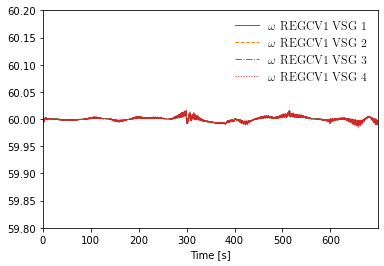

In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
ssa.TDS.plt.plot(ssa.REGCV1.omega, ytimes=60, fig=fig, ax=ax, show=False)
ax.set_ylim([59.8, 60.2])

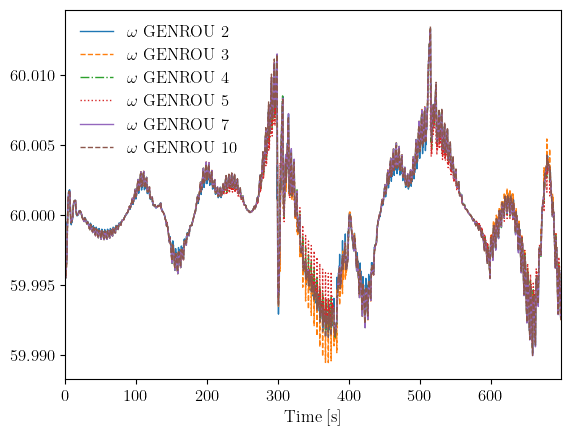

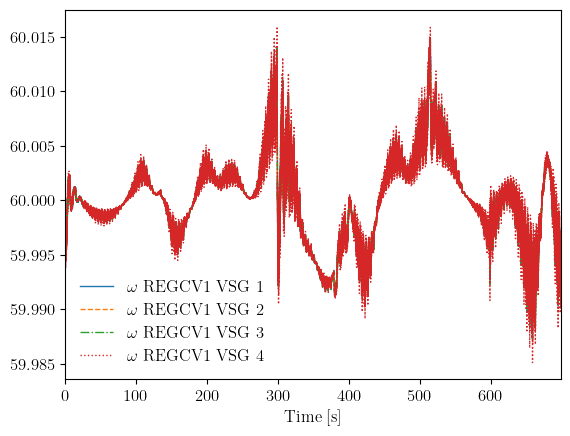

(59.9, 60.1)

In [21]:
ssa.TDS.plt.plot(ssa.GENROU.omega, ytimes=60)
fig, ax = ssa.TDS.plt.plot(ssa.REGCV1.omega, ytimes=60)
ax.set_ylim([59.9, 60.1])

In [22]:
ssa.REGCV1.as_df()[['idx', 'u', 'name', 'Tc', 'kw', 'kv',
       'M', 'D', 'Kpvd', 'Kivd', 'Kpvq',
       'Kivq', 'KpId', 'KiId', 'KpIq', 'KiIq']]

,idx,u,name,Tc,kw,kv,M,D,Kpvd,Kivd,Kpvq,Kivq,KpId,KiId,KpIq,KiIq
uid,,,,,,,,,,,,,,,,
0,VSG_1,1.0,VSG_1,0.01,0.0,0.0,2.0,0.5,5200.0,0.0,5200.0,0.0,1.0400,0.0,1.0400,0.0
1,VSG_2,1.0,VSG_2,0.01,0.0,0.0,6.0,3.0,5428.5,0.0,5428.5,0.0,1.0857,0.0,1.0857,0.0
2,VSG_3,1.0,VSG_3,0.01,0.0,0.0,2.0,0.5,4851.0,0.0,4851.0,0.0,0.9702,0.0,0.9702,0.0
3,VSG_4,1.0,VSG_4,0.01,0.0,0.0,2.0,0.5,8420.5,0.0,8420.5,0.0,1.6841,0.0,1.6841,0.0


In [23]:
ssa.REGCV1.as_df().columns

Index(['idx', 'u', 'name', 'bus', 'gen', 'coi2', 'Sn', 'fn', 'Tc', 'kw', 'kv',
       'M', 'D', 'ra', 'xs', 'gammap', 'gammaq', 'Kpvd', 'Kivd', 'Kpvq',
       'Kivq', 'KpId', 'KiId', 'KpIq', 'KiIq'],
      dtype='object')

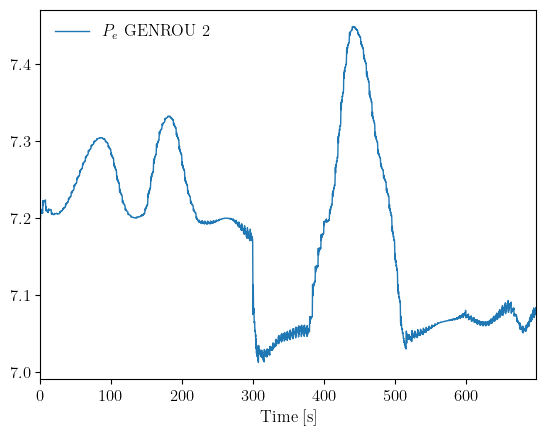

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:xlabel='Time [s]'>)

In [24]:
ssa.TDS.plt.plot(ssa.GENROU.Pe, a=(0))

In [25]:
load

1.039358429662416

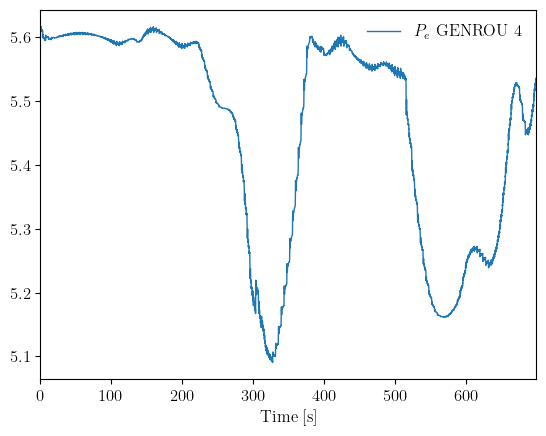

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:xlabel='Time [s]'>)

In [26]:
ssa.TDS.plt.plot(ssa.GENROU.Pe, a=(2))

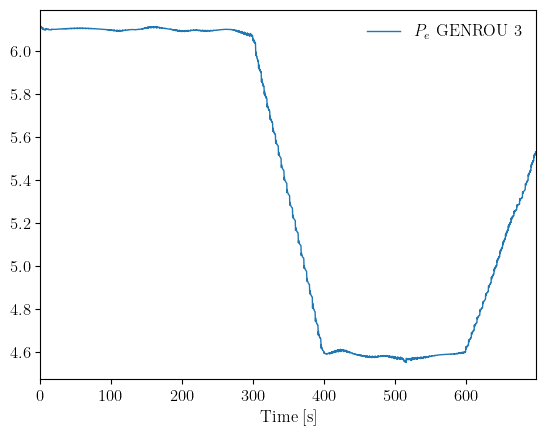

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:xlabel='Time [s]'>)

In [27]:
ssa.TDS.plt.plot(ssa.GENROU.Pe, a=(1))

In [28]:
visres

,gen,Sn,pg,pru,prd
0,PV_1,10.400,8.994614,0.005386,0.0
1,PV_2,8.360,9.000000,0.000000,0.0
2,PV_3,8.437,1.000000,0.000000,0.0
3,PV_4,11.748,7.000000,0.000000,0.0
4,PV_5,10.802,7.000000,0.000000,0.0
5,PV_6,10.857,0.885145,0.016146,0.0
6,PV_7,10.252,7.000000,0.000000,0.0
7,PV_8,9.702,6.994614,0.005386,0.0
8,PV_9,16.841,9.994614,0.005386,0.0
9,Slack_10,11.990,3.000000,0.000000,0.0


In [29]:
ssp_res

,stg_idx,p,q,vm_pu,bus_idx,controllable,dg_idx,syg_idx,gov_idx,exc_idx,rg_idx,p0,pref_step,pref_delta,pref
0,PV_1,7.194614,1.495886,1.084399,30,True,False,False,False,False,VSG_1,7.200000,-5.386048e-03,-5.386048e-03,7.194614
1,PV_2,7.200000,2.083885,1.014936,31,True,False,GENROU_2,TGOV1_2,IEEEX1_2,False,7.200000,-1.430724e-08,-1.430724e-08,7.200000
2,PV_3,5.527706,0.956448,1.040914,32,True,False,GENROU_3,TGOV1_3,IEEEX1_3,False,4.597452,9.302539e-01,9.302539e-01,5.527706
3,PV_4,5.600000,0.962383,1.042124,33,True,False,GENROU_4,TGOV1_4,IEEEX1_4,False,5.600000,-1.070155e-08,-1.070155e-08,5.600000
4,PV_5,5.600000,1.495374,1.051695,34,True,False,GENROU_5,TGOV1_5,IEEEX1_5,False,5.600000,-1.070225e-08,-1.070225e-08,5.600000
5,PV_6,6.383854,2.096519,1.097264,35,True,False,False,False,False,VSG_2,6.400000,-1.614645e-02,-1.614645e-02,6.383854
6,PV_7,5.600000,0.529790,1.100000,36,True,False,GENROU_7,TGOV1_7,IEEEX1_7,False,5.600000,-1.514139e-08,-1.514139e-08,5.600000
7,PV_8,5.594614,0.445771,1.079131,37,True,False,False,False,False,VSG_3,5.600000,-5.386050e-03,-5.386050e-03,5.594614
8,PV_9,7.994614,1.039289,1.087383,38,True,False,False,False,False,VSG_4,8.000000,-5.386049e-03,-5.386049e-03,7.994614
9,Slack_10,4.558161,0.279206,1.085972,39,True,False,GENROU_10,TGOV1_10,IEEEX1_10,False,4.142564,4.155975e-01,4.155975e-01,4.558161


In [30]:
ssa.TGOV1N.pref.v

array([7.19999998, 5.52770634, 5.59999999, 5.59999999, 5.59999998,
       4.55816103])

In [31]:
ssa.REGCV1.Pref2.v

array([7.19461395, 6.38385354, 5.59461395, 7.99461395])

In [32]:
ssa.REGCV1.M.v

array([2., 6., 2., 2.])

In [33]:
ssa.REGCV1.D.v

array([0.5, 3. , 0.5, 0.5])

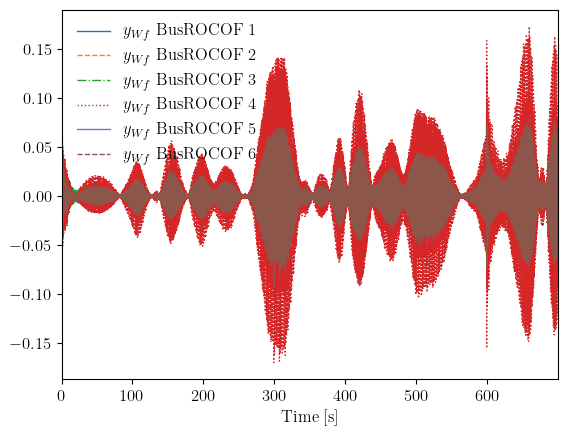

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:xlabel='Time [s]'>)

In [34]:
ssa.TDS.plt.plot(ssa.BusROCOF.Wf_y, ytimes=60)